In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import MSTL

In [2]:
neft_data = pd.read_excel('D:\Personal\Education\PGDBA 2023-25\Sem1\SPA\TimeSeries Project\Payment Systems Volume Payment Transactions RBI Operated National Electronic Funds Transfer NEFT.xlsx')[:-7]

In [3]:
neft_data['Date'] = neft_data['Date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').strftime('%Y-%d-%m  00:00:00') if isinstance(x, str) else x)
neft_data['Date'] = pd.to_datetime(neft_data['Date'], format='%Y-%d-%m %H:%M:%S')
neft_data.rename(columns = {"Payment Volume (Unit mn)": "Volume"}, inplace = True)
print(neft_data)

           Date     Volume
0    2020-06-01  17.211000
1    2020-06-02  10.006772
2    2020-06-03  10.036426
3    2020-06-04   9.465655
4    2020-06-05  11.126259
...         ...        ...
1252 2023-11-05  11.863879
1253 2023-11-06  25.645393
1254 2023-11-07  30.939605
1255 2023-11-08  30.113271
1256 2023-11-09  28.903590

[1257 rows x 2 columns]


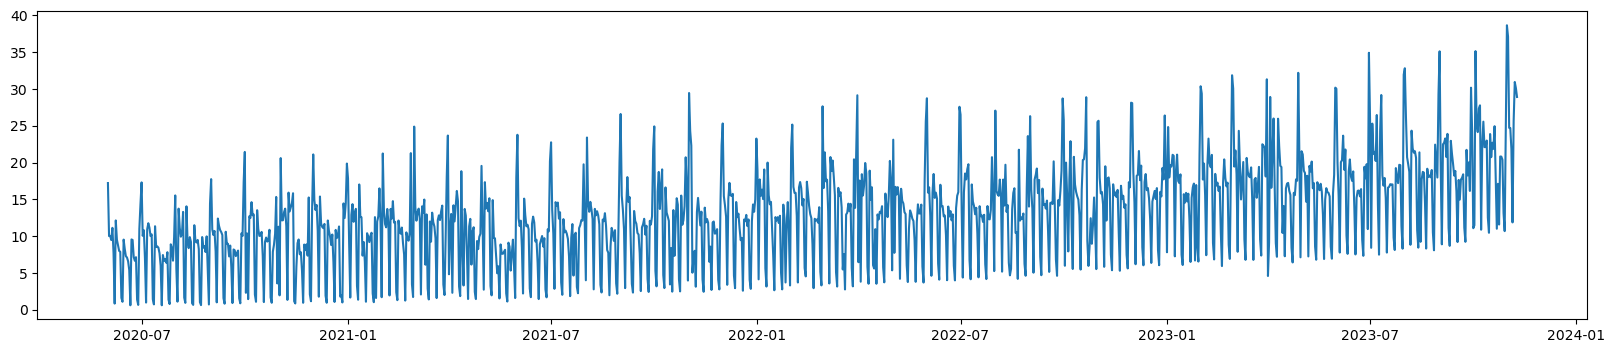

In [4]:
#Plot Entire Graph
plt.figure(figsize=(20,4))
plt.plot(neft_data['Date'], neft_data['Volume'])

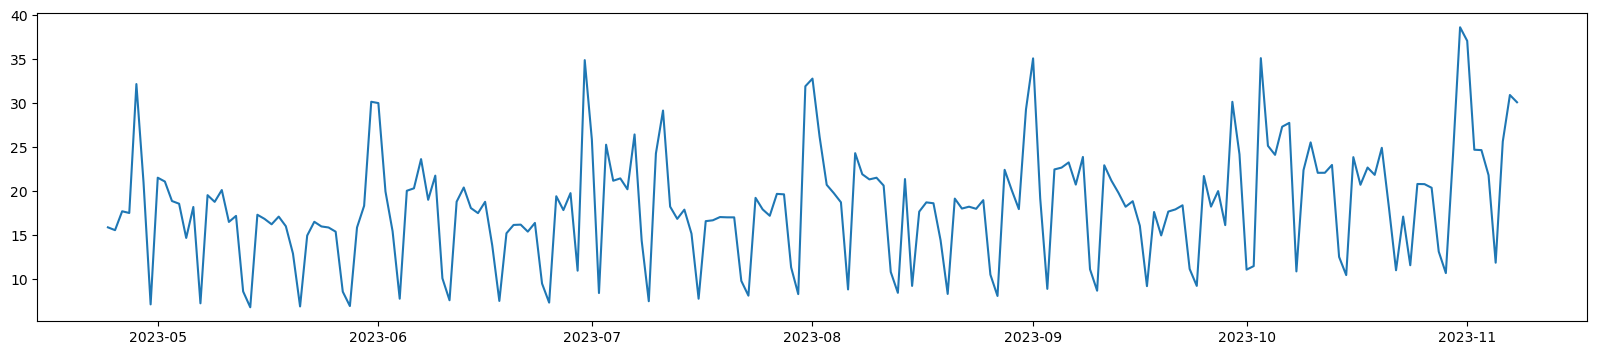

In [5]:
#Plot A Sub-Section
plt.figure(figsize=(20,4))
neft_data_last_200 = neft_data[-200:-1]
plt.plot(neft_data_last_200['Date'], neft_data_last_200['Volume'])

In [6]:
#Train Test Split
neft_test = neft_data[-30:-1]
neft_train = neft_data[0:len(neft_data) - 30]

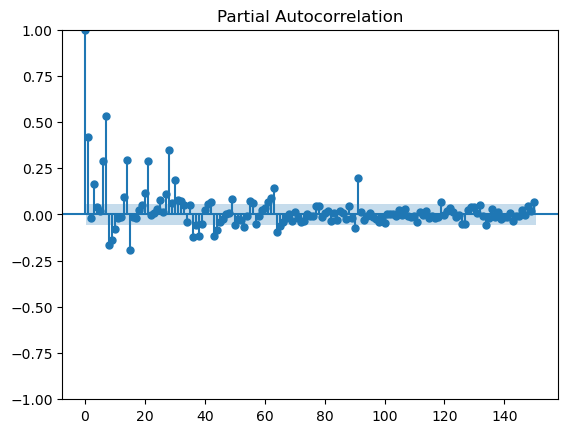

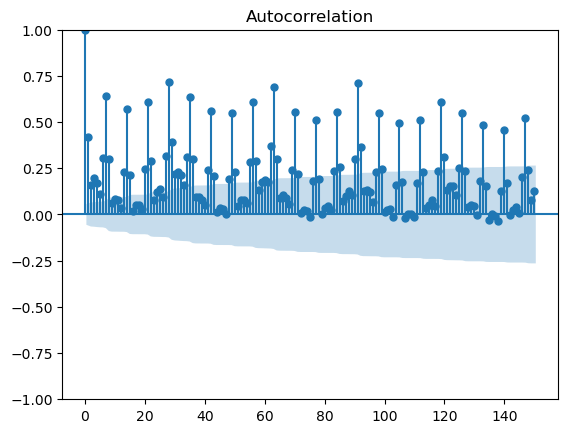

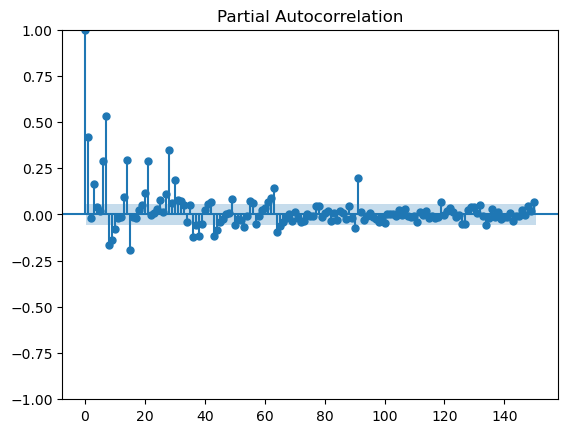

In [7]:
plot_acf(neft_train['Volume'], lags=150)
plot_pacf(neft_train['Volume'], lags=150)

# Treating Seasonality (30) as an exogenous variable

In [9]:
from pmdarima.arima import auto_arima

# prepare Fourier terms
exog = pd.DataFrame({'date': neft_data.Date})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))

for i in range(1, 5):
    exog['sin{}'.format(i)] = np.sin(2 * i * np.pi * exog.index.dayofyear / 30.42)
    exog['cos{}'.format(i)] = np.cos(2 * i * np.pi * exog.index.dayofyear / 30.42)
exog.drop(columns=['date'], inplace=True)
exog.reset_index(drop=True, inplace=True)
exog_to_train = exog.iloc[:(len(neft_data)-30)]
exog_to_test = exog.iloc[(len(neft_data)-30):]


In [10]:
import itertools

#Range of p, d, q as identified from the ACF and PACF plots present in the earlier notebooks

p = list(range(0, 4))
d = list(range(1, 2))
q = list(range(0, 3))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
model_evaluation = pd.DataFrame(columns = ['Description', 'AIC'], index = range(0, len(pdq)*len(seasonal_pdq)))
print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
index = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(neft_train.Volume,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False,
                exog = exog_to_train)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            model_evaluation.loc[index].Description = "ARIMA{}x{}".format(param, param_seasonal)
            model_evaluation.loc[index].AIC = results.aic
            index += 1
        except Exception as e:
            print("Exception: {}".format(e))
            break

Examples of parameter combinations for Seasonal ARIMA...
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:7924.72647767297
ARIMA(0, 1, 0)x(0, 1, 1, 7) - AIC:7010.569131080627
ARIMA(0, 1, 0)x(0, 1, 2, 7) - AIC:6972.390337825456
ARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC:7478.55373518281
ARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC:7012.45987314414
ARIMA(0, 1, 0)x(1, 1, 2, 7) - AIC:6970.872226156603
ARIMA(0, 1, 0)x(2, 1, 0, 7) - AIC:7316.650294945985
ARIMA(0, 1, 0)x(2, 1, 1, 7) - AIC:6979.3157607711455
ARIMA(0, 1, 0)x(2, 1, 2, 7) - AIC:6972.868011810451
ARIMA(0, 1, 0)x(3, 1, 0, 7) - AIC:7147.209189277889
ARIMA(0, 1, 0)x(3, 1, 1, 7) - AIC:6947.326997543085
ARIMA(0, 1, 0)x(3, 1, 2, 7) - AIC:6942.0864793876035
ARIMA(0, 1, 1)x(0, 1, 0, 7) - AIC:7073.463588979665
ARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC:6219.158492549309
ARIMA(0, 1, 1)x(0, 1, 2, 7) - AIC:6189.053492772961
ARIMA(0, 1, 1)x(1, 1, 0, 7) - AIC:6686.568055818361
ARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC:6223.131950595559
ARIMA(0, 1, 1)x(1, 1, 2, 7) - AIC:6188.71971740238
ARIMA(0, 

C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(2, 1, 2, 7) - AIC:6187.392156660346
ARIMA(0, 1, 2)x(3, 1, 0, 7) - AIC:6355.234066924324


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 2)x(3, 1, 1, 7) - AIC:6170.198301983819
ARIMA(0, 1, 2)x(3, 1, 2, 7) - AIC:6169.988443435436
ARIMA(1, 1, 0)x(0, 1, 0, 7) - AIC:7638.788865008926
ARIMA(1, 1, 0)x(0, 1, 1, 7) - AIC:6767.471697053174
ARIMA(1, 1, 0)x(0, 1, 2, 7) - AIC:6734.889726381276
ARIMA(1, 1, 0)x(1, 1, 0, 7) - AIC:7228.054772590083
ARIMA(1, 1, 0)x(1, 1, 1, 7) - AIC:6771.066011246577
ARIMA(1, 1, 0)x(1, 1, 2, 7) - AIC:6734.870658584352
ARIMA(1, 1, 0)x(2, 1, 0, 7) - AIC:7058.148974217838
ARIMA(1, 1, 0)x(2, 1, 1, 7) - AIC:6737.005918081536
ARIMA(1, 1, 0)x(2, 1, 2, 7) - AIC:6736.867674987002
ARIMA(1, 1, 0)x(3, 1, 0, 7) - AIC:6911.832778019966
ARIMA(1, 1, 0)x(3, 1, 1, 7) - AIC:6705.011233746101
ARIMA(1, 1, 0)x(3, 1, 2, 7) - AIC:6702.523169876142
ARIMA(1, 1, 1)x(0, 1, 0, 7) - AIC:7075.325249725024
ARIMA(1, 1, 1)x(0, 1, 1, 7) - AIC:6220.586306965588
ARIMA(1, 1, 1)x(0, 1, 2, 7) - AIC:6190.443926867065
ARIMA(1, 1, 1)x(1, 1, 0, 7) - AIC:6681.907234695409
ARIMA(1, 1, 1)x(1, 1, 1, 7) - AIC:6224.5194251762105
ARIMA(1, 1,

C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(0, 1, 1, 7) - AIC:6217.552240870873
ARIMA(1, 1, 2)x(0, 1, 2, 7) - AIC:6187.949098795974


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 1, 0, 7) - AIC:6655.123064988844
ARIMA(1, 1, 2)x(1, 1, 1, 7) - AIC:6219.5314165904365


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(1, 1, 2, 7) - AIC:6187.129816837976


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 1, 0, 7) - AIC:6506.280585122426
ARIMA(1, 1, 2)x(2, 1, 1, 7) - AIC:6198.667832324805


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(2, 1, 2, 7) - AIC:6189.144840461147


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(3, 1, 0, 7) - AIC:6350.485091896528


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(3, 1, 1, 7) - AIC:6168.429549010363


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2)x(3, 1, 2, 7) - AIC:6165.018150007947
ARIMA(2, 1, 0)x(0, 1, 0, 7) - AIC:7442.560838376777
ARIMA(2, 1, 0)x(0, 1, 1, 7) - AIC:6561.079392854899
ARIMA(2, 1, 0)x(0, 1, 2, 7) - AIC:6526.816293763377
ARIMA(2, 1, 0)x(1, 1, 0, 7) - AIC:7033.320555884136
ARIMA(2, 1, 0)x(1, 1, 1, 7) - AIC:6557.172983921131
ARIMA(2, 1, 0)x(1, 1, 2, 7) - AIC:6528.509571992659
ARIMA(2, 1, 0)x(2, 1, 0, 7) - AIC:6860.065224642556
ARIMA(2, 1, 0)x(2, 1, 1, 7) - AIC:6524.598468364638
ARIMA(2, 1, 0)x(2, 1, 2, 7) - AIC:6526.336561608972
ARIMA(2, 1, 0)x(3, 1, 0, 7) - AIC:6715.218734410764
ARIMA(2, 1, 0)x(3, 1, 1, 7) - AIC:6491.328539865141


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 0)x(3, 1, 2, 7) - AIC:6489.387416543582


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(0, 1, 0, 7) - AIC:7067.103645215799
ARIMA(2, 1, 1)x(0, 1, 1, 7) - AIC:6204.565960578969
ARIMA(2, 1, 1)x(0, 1, 2, 7) - AIC:6172.940810836955
ARIMA(2, 1, 1)x(1, 1, 0, 7) - AIC:6665.66015588506
ARIMA(2, 1, 1)x(1, 1, 1, 7) - AIC:6207.115650908196
ARIMA(2, 1, 1)x(1, 1, 2, 7) - AIC:6173.459387051986
ARIMA(2, 1, 1)x(2, 1, 0, 7) - AIC:6487.729656189359
ARIMA(2, 1, 1)x(2, 1, 1, 7) - AIC:6175.150090419045


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1)x(2, 1, 2, 7) - AIC:6175.457321152512
ARIMA(2, 1, 1)x(3, 1, 0, 7) - AIC:6323.501510326554
ARIMA(2, 1, 1)x(3, 1, 1, 7) - AIC:6145.4729080906
ARIMA(2, 1, 1)x(3, 1, 2, 7) - AIC:6139.58893404033
ARIMA(2, 1, 2)x(0, 1, 0, 7) - AIC:7286.7558547346725


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 1, 1, 7) - AIC:6204.889110689795


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(0, 1, 2, 7) - AIC:6178.3056398508215


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 0, 7) - AIC:6670.748540030355


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 1, 7) - AIC:6203.753875210863


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(1, 1, 2, 7) - AIC:6170.548278355954


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 0, 7) - AIC:6491.5077217898015


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 1, 7) - AIC:6191.753811405111


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(2, 1, 2, 7) - AIC:6179.699169647325


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(3, 1, 0, 7) - AIC:6327.384014961581


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(3, 1, 1, 7) - AIC:6232.520005073446


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2)x(3, 1, 2, 7) - AIC:6162.930507104349
ARIMA(3, 1, 0)x(0, 1, 0, 7) - AIC:7344.948982282114
ARIMA(3, 1, 0)x(0, 1, 1, 7) - AIC:6466.061638528441
ARIMA(3, 1, 0)x(0, 1, 2, 7) - AIC:6431.418007135307
ARIMA(3, 1, 0)x(1, 1, 0, 7) - AIC:6928.396011199529
ARIMA(3, 1, 0)x(1, 1, 1, 7) - AIC:6456.618054886922
ARIMA(3, 1, 0)x(1, 1, 2, 7) - AIC:6432.469420489275
ARIMA(3, 1, 0)x(2, 1, 0, 7) - AIC:6765.292628373487
ARIMA(3, 1, 0)x(2, 1, 1, 7) - AIC:6424.864839508004


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 0)x(2, 1, 2, 7) - AIC:6424.9769931759765
ARIMA(3, 1, 0)x(3, 1, 0, 7) - AIC:6616.5736174774975
ARIMA(3, 1, 0)x(3, 1, 1, 7) - AIC:6391.690462784603
ARIMA(3, 1, 0)x(3, 1, 2, 7) - AIC:6388.306635583032


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(0, 1, 0, 7) - AIC:7063.8959471916405
ARIMA(3, 1, 1)x(0, 1, 1, 7) - AIC:6206.213291156057
ARIMA(3, 1, 1)x(0, 1, 2, 7) - AIC:6174.536159308735


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(1, 1, 0, 7) - AIC:6662.625688309932
ARIMA(3, 1, 1)x(1, 1, 1, 7) - AIC:6203.679659691474
ARIMA(3, 1, 1)x(1, 1, 2, 7) - AIC:6175.10956041584
ARIMA(3, 1, 1)x(2, 1, 0, 7) - AIC:6484.892161959586
ARIMA(3, 1, 1)x(2, 1, 1, 7) - AIC:6172.256161116613


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 1)x(2, 1, 2, 7) - AIC:6172.721796515729
ARIMA(3, 1, 1)x(3, 1, 0, 7) - AIC:6320.319505404941
ARIMA(3, 1, 1)x(3, 1, 1, 7) - AIC:6141.885927253874
ARIMA(3, 1, 1)x(3, 1, 2, 7) - AIC:6136.217964796877
ARIMA(3, 1, 2)x(0, 1, 0, 7) - AIC:7010.260157243572


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(0, 1, 1, 7) - AIC:6206.302538409092


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(0, 1, 2, 7) - AIC:6172.653110004149


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(1, 1, 0, 7) - AIC:6666.84553765382


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(1, 1, 1, 7) - AIC:6211.136067089885


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(1, 1, 2, 7) - AIC:6173.555449299458


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(2, 1, 0, 7) - AIC:6488.238750132149


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(2, 1, 1, 7) - AIC:6181.931752456141


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(2, 1, 2, 7) - AIC:6174.607826251677


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 0, 7) - AIC:6359.546801464772


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 1, 7) - AIC:6289.082703552795


C:\Users\athar\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2)x(3, 1, 2, 7) - AIC:6138.275309114522


In [11]:
model_evaluation.sort_values('AIC')

,Description,AIC
131,"ARIMA(3, 1, 1)x(3, 1, 2, 7)",6136.217965
143,"ARIMA(3, 1, 2)x(3, 1, 2, 7)",6138.275309
95,"ARIMA(2, 1, 1)x(3, 1, 2, 7)",6139.588934
130,"ARIMA(3, 1, 1)x(3, 1, 1, 7)",6141.885927
94,"ARIMA(2, 1, 1)x(3, 1, 1, 7)",6145.472908
...,...,...
108,"ARIMA(3, 1, 0)x(0, 1, 0, 7)",7344.948982
72,"ARIMA(2, 1, 0)x(0, 1, 0, 7)",7442.560838
3,"ARIMA(0, 1, 0)x(1, 1, 0, 7)",7478.553735
36,"ARIMA(1, 1, 0)x(0, 1, 0, 7)",7638.788865


In [34]:
mod = sm.tsa.statespace.SARIMAX(neft_train.Volume,
            order=[0, 1, 1],
            seasonal_order=[0, 1, 1, 7],
            enforce_stationarity=False,
            enforce_invertibility=False,
                exog = exog_to_train)
results = mod.fit()

In [35]:
# .summary() - 5, 1, 0; 2, 0, 0, 7

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                            Volume   No. Observations:                 1227
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -3098.579
Date:                           Wed, 13 Dec 2023   AIC                           6219.158
Time:                                   01:15:10   BIC                           6275.241
Sample:                                        0   HQIC                          6240.276
                                          - 1227                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin1           1.4465      0.164      8.840      0.000       1.126       1.767
cos1           2.0880      0.136     15.320      0.000       1.821       2.355
sin2           0.4780      0.151      3.172      0.002       0.183       0.773
cos2           1.0225      0.156      6.550      0.000       0.717       1.328
sin3          -0.3571      0.157     -2.277      0.023      -0.665      -0.050
cos3           0.9769      0.147      6.623      0.000       0.688       1.266
sin4          -0.3602      0.137     -2.636      0.008      -0.628      -0.092
cos4           0.8142      0.150      5.411      0.000       0.519       1.109
ma.L1         -1.0145      0.006   -177.296      0.000      -1.026      -1.003
ma.S.L7       -0.9815      0.010    -97.780      0.000      -1.001      -0.962
sigma2         9.3497      0.252     37.045      0.000       8.855       9.844
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):               529.51
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
y_arima_exog_forecast = results.predict(start = 1228, end = 1256, exog = exog_to_test)

MAE: 3.53
MSE: 21.17
RMSE: 4.60
MAPE: 16.63%
sMAPE: 17.14%


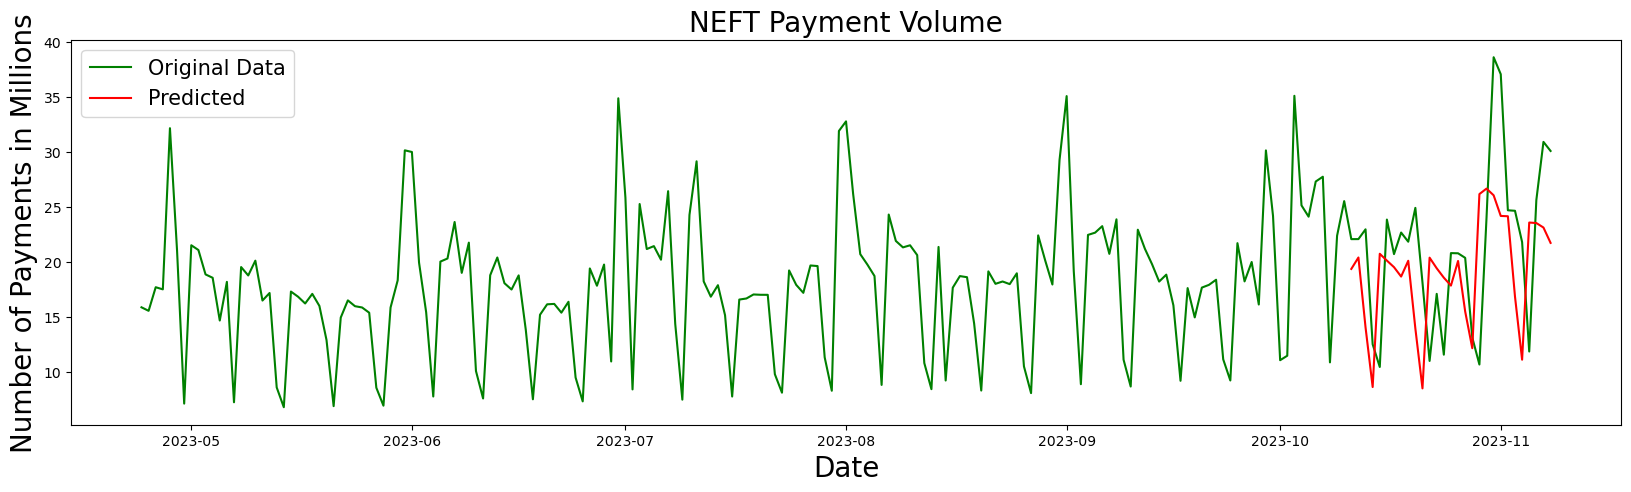

In [37]:
plt.figure(figsize=(20,5))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Payments in Millions', fontsize=20)
plt.title('NEFT Payment Volume', fontsize=20)
plt.plot(neft_data['Date'][-200:-1], neft_data['Volume'][-200:-1], color = 'green', label="Original Data")
# plt.plot(neft_train['Date'][-200:-1], neft_train['Volume'][-200:-1], color = 'black')
plt.plot(neft_test['Date'], y_arima_exog_forecast[:29], color = 'red', label="Predicted")
plt.legend(loc="upper left", fontsize = 15)

# Calculate errors
errors = neft_test.Volume - y_arima_exog_forecast[:29]
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(errors / neft_test.Volume)) * 100
smape = np.mean(2 * np.abs(errors) / (np.abs(neft_test.Volume) + np.abs(y_arima_exog_forecast[:29]))) * 100

# Print results
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

In [47]:
results.resid

0       12.769977
1       -5.992263
2        1.310642
3        0.201807
4        1.748021
          ...    
1222     4.700658
1223    11.300414
1224    -0.519781
1225    -0.781846
1226     3.653480
Length: 1227, dtype: float64

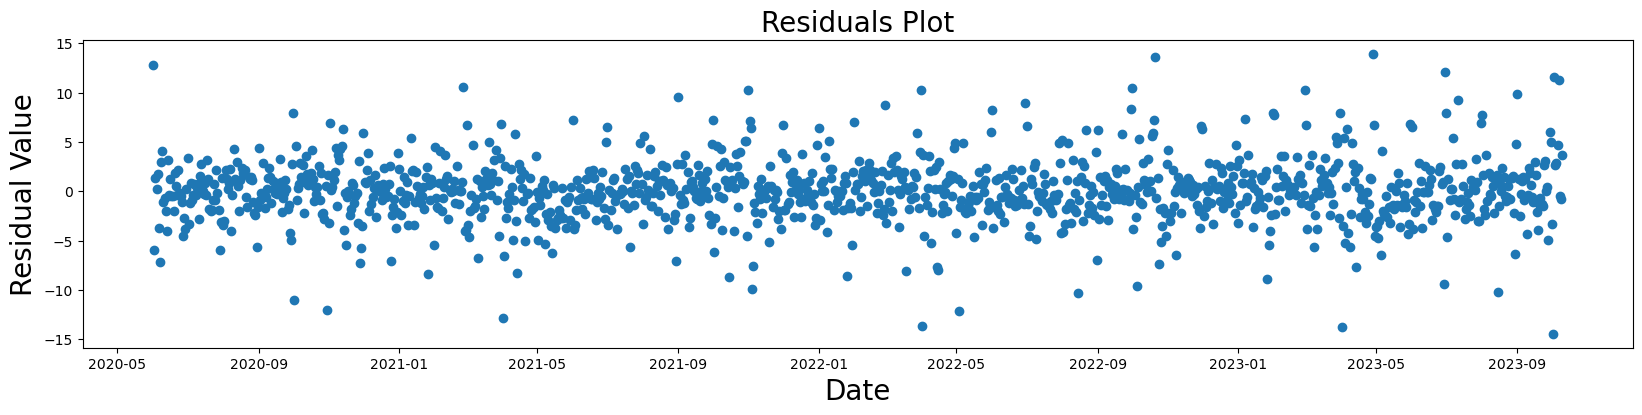

In [48]:
plt.figure(figsize=(20,4))
plt.title("Residuals Plot", fontsize=20)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Residual Value", fontsize=20)
plt.scatter(neft_train['Date'], results.resid)

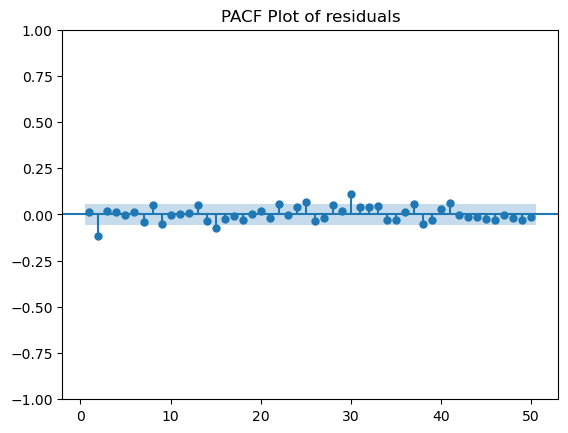

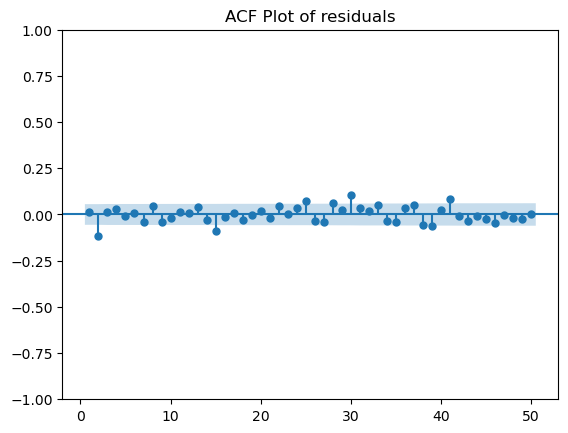

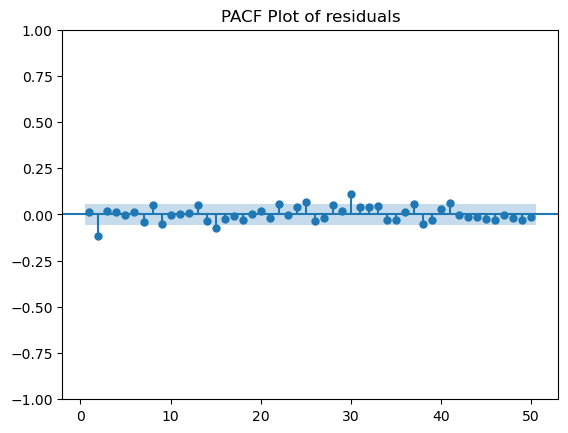

In [49]:
plot_acf(results.resid, lags=50, zero=False, title="ACF Plot of residuals")
plot_pacf(results.resid, lags=50, zero=False, title="PACF Plot of residuals")

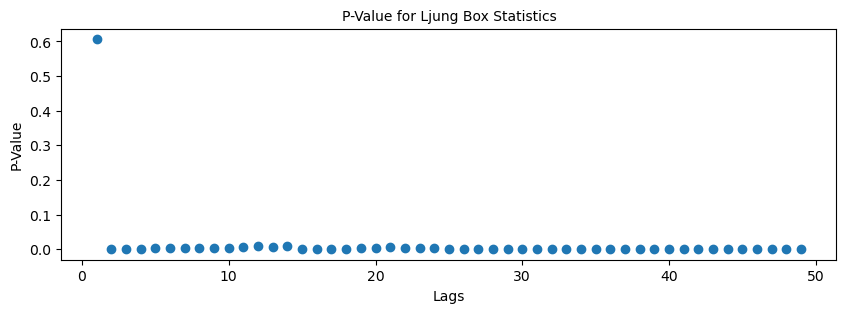

In [51]:
plt.figure(figsize = (10, 3))
plt.title("P-Value for Ljung Box Statistics", fontsize=10)
plt.xlabel("Lags", fontsize=10)
plt.ylabel("P-Value", fontsize=10)
plt.scatter(range(0, 50), sm.stats.acorr_ljungbox(results.resid, lags=range(0, 50), return_df=True).lb_pvalue)

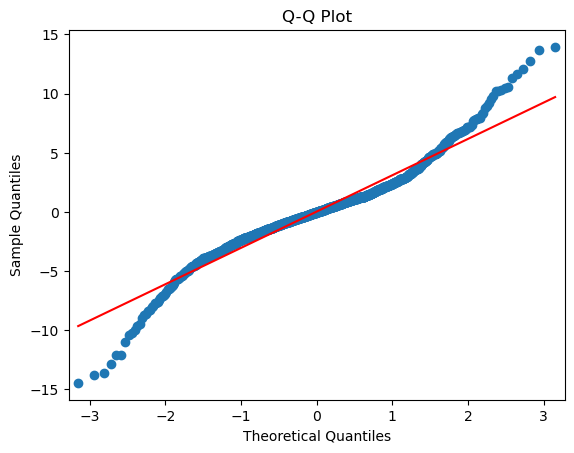

In [53]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(results.resid, line='r')
plt.title("Q-Q Plot")
plt.show()